In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [4]:
init_weight_dict = {'conv1.weight': (-0.0002266301744384691, 0.07788292318582535), 
                    'conv1.bias': (-0.06533964723348618, 0.11781848967075348), 
                    'conv2.weight': (-0.0124916797503829, 0.044476691633462906), 
                    'conv2.bias': (-0.010315056890249252, 0.06136268749833107), 
                    'fc1.weight': (-0.004733316134661436, 0.04221488535404205), 
                    'fc1.bias': (-0.004896007478237152, 0.11825607717037201)}

In [5]:
# change the CNN class to have 1 fc layer only

class CNNSingleFC(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, num_classes)  # Single FC layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (64, 16, 16)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)                         # Single FC layer
        return x

In [6]:
# convert the CNN class to a Bayesian CNN with 1 fc layer only, with the weight initialization from init_weight_dict
class oldBayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(init_weight_dict['conv1.weight'][0], init_weight_dict['conv1.weight'][1]).expand([32, 3, 3, 3]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(init_weight_dict['conv1.bias'][0], init_weight_dict['conv1.bias'][1]).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2) #initially padding=1 kernel_size=3, without stride
        self.conv2.weight = PyroSample(dist.Normal(init_weight_dict['conv2.weight'][0], init_weight_dict['conv2.weight'][1]).expand([64, 32, 3, 3]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(init_weight_dict['conv2.bias'][0], init_weight_dict['conv2.bias'][1]).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(init_weight_dict['fc1.weight'][0], init_weight_dict['fc1.weight'][1]).expand([num_classes, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(init_weight_dict['fc1.bias'][0], init_weight_dict['fc1.bias'][1]).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)
        
        # THIS IS THE MISSING PIECE: Define the likelihood
        if y is not None:
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

In [7]:
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 10.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 10.).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2) #initially padding=1 kernel_size=3, without stride
        self.conv2.weight = PyroSample(dist.Normal(0., 10.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 10.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(0., 10.).expand([num_classes, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)
        
        # THIS IS THE MISSING PIECE: Define the likelihood
        if y is not None:
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

In [8]:
class BayesianCNNSingleFC_mod1(PyroModule):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(0., 10.).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(0., 10.).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(0., 10.).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(0., 10.).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Updated FC layer - input size is now 64 (after global avg pooling) instead of 64*16*16
        self.fc1 = PyroModule[nn.Linear](64, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(0., 10.).expand([num_classes, 64]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))  # -> (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # -> (64, 16, 16)
        
        # Apply global average pooling
        x = self.global_avg_pool(x)  # -> (64, 1, 1)
        x = x.view(x.size(0), -1)    # -> (64,)
        
        # Apply dropout before final layer
        x = self.dropout(x)
        
        logits = self.fc1(x)
        
        # Define the likelihood
        if y is not None:
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

In [9]:
def load_data(batch_size=64):  # Changed from 54 to 64 to match deterministic CNN
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    # Use fixed random seed for reproducible splits
    torch.manual_seed(42)
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [10]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn.functional as F

# 48.13% accuracy

class BayesianCNN_PyroEquivalent(PyroModule):
    def __init__(self, num_classes=10, const_bnn_prior_parameters=None):
        super().__init__()
        
        # Use provided parameters or defaults
        if const_bnn_prior_parameters is None:
            const_bnn_prior_parameters = {
                "prior_mu": 0.0,
                "prior_sigma": 1.0,
                "posterior_mu_init": 0.0,
                "posterior_rho_init": -3.0,
                "type": "Reparameterization",
                "moped_enable": False,
                "moped_delta": 0.5,
            }
        
        prior_mu = const_bnn_prior_parameters["prior_mu"]
        prior_sigma = const_bnn_prior_parameters["prior_sigma"]
        
        # Conv Layer 1: 3 -> 32, kernel_size=5, stride=1, padding=2
        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([32, 3, 5, 5]).to_event(4)
        )
        self.conv1.bias = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([32]).to_event(1)
        )
        
        # Conv Layer 2: 32 -> 64, kernel_size=5, stride=1, padding=2
        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([64, 32, 5, 5]).to_event(4)
        )
        self.conv2.bias = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([64]).to_event(1)
        )
        
        # MaxPool layer (deterministic)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # FC Layer 1: 64*16*16 -> 128 (same as original model_bcnn)
        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, 128)
        self.fc1.weight = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([128, 64 * 16 * 16]).to_event(2)
        )
        self.fc1.bias = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([128]).to_event(1)
        )
        
        # FC Layer 2: 128 -> 10 (output layer, same as original model_bcnn)
        self.fc2 = PyroModule[nn.Linear](128, num_classes)
        self.fc2.weight = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([num_classes, 128]).to_event(2)
        )
        self.fc2.bias = PyroSample(
            dist.Normal(prior_mu, prior_sigma).expand([num_classes]).to_event(1)
        )


    def forward(self, x, y=None):
        # Forward pass identical to original CNN
        x = self.pool(F.relu(self.conv1(x)))   # -> (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (64, 16, 16)
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))                # First FC layer with ReLU
        logits = self.fc2(x)                   # Second FC layer (output)
        
        # Define likelihood for training
        if y is not None:
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

# Usage example:
const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 10.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Reparameterization",
    "moped_enable": False,
    "moped_delta": 0.5,
}

# Create the Pyro equivalent model
pyro_model_bcnn = BayesianCNN_PyroEquivalent(
    num_classes=10, 
    const_bnn_prior_parameters=const_bnn_prior_parameters
)

In [11]:
import pyro
import pyro.infer
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm import tqdm

# 1. Instantiate model and guide - fix device consistency
num_classes = 10
bayesian_model = BayesianCNNSingleFC_mod1(num_classes=num_classes).to(device)  # Use .to(device) instead of .cuda()

#bayesian_model = BayesianCNN_PyroEquivalent(
#    num_classes=10, 
#    const_bnn_prior_parameters=const_bnn_prior_parameters
#)

guide = AutoDiagonalNormal(bayesian_model)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

# 3. Training function
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")


In [12]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)
train_svi(bayesian_model, guide, svi, train_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 400/400 [01:34<00:00,  4.23it/s]


Epoch 1 - ELBO Loss: 1511075.5845


Epoch 2/10: 100%|██████████| 400/400 [01:34<00:00,  4.23it/s]


Epoch 2 - ELBO Loss: 484889.3782


Epoch 3/10: 100%|██████████| 400/400 [01:33<00:00,  4.27it/s]


Epoch 3 - ELBO Loss: 315563.9143


Epoch 4/10: 100%|██████████| 400/400 [01:47<00:00,  3.71it/s]


Epoch 4 - ELBO Loss: 263509.3280


Epoch 5/10: 100%|██████████| 400/400 [01:39<00:00,  4.03it/s]


Epoch 5 - ELBO Loss: 241220.4234


Epoch 6/10: 100%|██████████| 400/400 [01:43<00:00,  3.86it/s]


Epoch 6 - ELBO Loss: 228621.2937


Epoch 7/10: 100%|██████████| 400/400 [01:17<00:00,  5.19it/s]


Epoch 7 - ELBO Loss: 220017.8751


Epoch 8/10: 100%|██████████| 400/400 [01:05<00:00,  6.08it/s]


Epoch 8 - ELBO Loss: 212817.2755


Epoch 9/10: 100%|██████████| 400/400 [00:58<00:00,  6.84it/s]


Epoch 9 - ELBO Loss: 206204.5914


Epoch 10/10: 100%|██████████| 400/400 [00:50<00:00,  7.88it/s]

Epoch 10 - ELBO Loss: 199588.6221


In [13]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_svi(model, guide, test_loader, num_samples=10):
    model.eval()
    correct = 0
    total = 0

    #device = next(model.parameters()).device  # Get the device where the model is allocated

    with torch.no_grad():  # Add no_grad for efficiency
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)  # Fix: move to device

            # Accumulate logits from multiple samples
            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                # Sample from the guide (posterior) and replay through model
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            # Average the logits across samples
            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy over {num_samples} MC samples: {accuracy * 100:.2f}%")
    return accuracy


In [14]:
#evaluate_svi(bayesian_model, guide, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]

Accuracy over 10 MC samples: 44.76%


0.4475925925925926

In [ ]:
# singleFC with dropout : 44.75%

In [21]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, test_loader, num_samples=10):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [29]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


In [30]:
cm = confusion_matrix(all_labels, all_predictions)

In [31]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

Accuracy from confusion matrix: 44.796296%


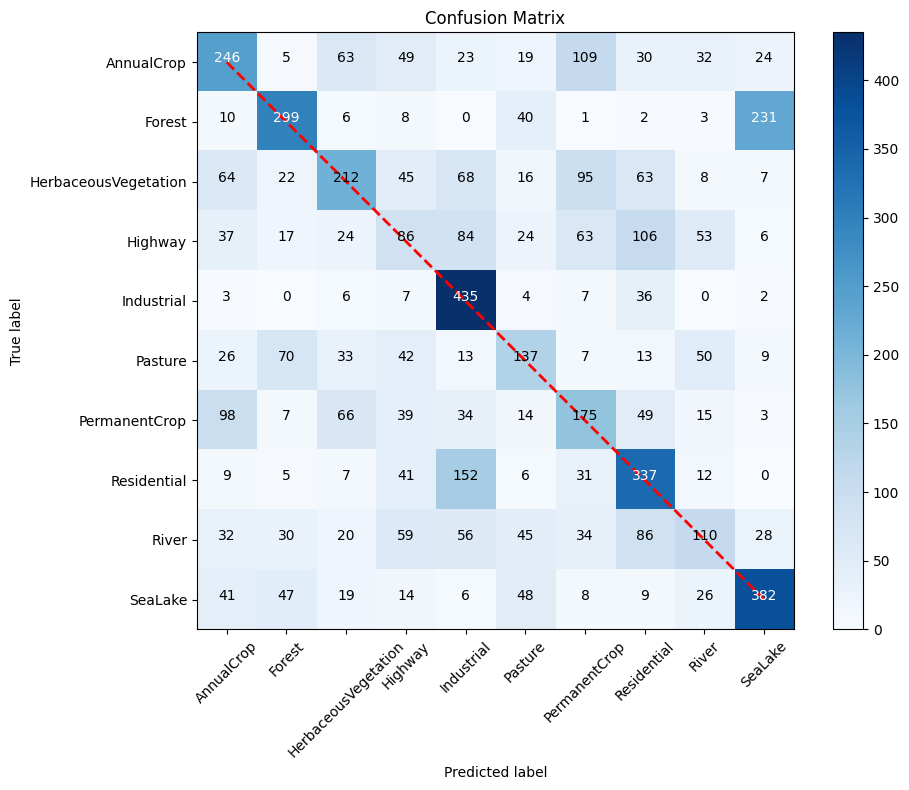

In [32]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

## Let's try different evaluation method

In [ ]:
from tqdm import tqdm

def evaluate_model_bcnn_ensemble_with_uncertainty(model, guide, loader, device="cpu", n_samples=20, alpha=0.8):
    """Returns mean prediction probabilities over n posterior samples"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            batch_preds = []
            
            for _ in range(n_samples):
                # Sample from the guide (posterior) and replay through model
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                output = replayed_model(images)
                prob = F.softmax(output, dim=1)
                batch_preds.append(prob)
                
            mean_probs = torch.stack(batch_preds).mean(dim=0)  # [batch_size, num_classes]

            confidences, pred_classes = mean_probs.max(dim=1)
            known_mask = confidences >= alpha
            unknown_mask = ~known_mask

            correct += (pred_classes == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Ensemble Accuracy: {accuracy:.2f}%")
    return accuracy

def complete_evaluate_model_bcnn_ensemble_with_uncertainty(model, 
                                                           guide,
                                                           loader, 
                                                           device="cpu",
                                                           reproduce_seed=42, 
                                                           n_samples=20, 
                                                           alpha=0.8,
                                                           teta=0):
    """Returns comprehensive evaluation metrics including uncertainty quantification"""
    model.eval()
    correct = 0
    total = 0
    unknown_count = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            batch_preds = []
            
            for _ in range(n_samples):
                # Sample from the guide (posterior) and replay through model
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                output = replayed_model(images)
                prob = F.softmax(output, dim=1)
                batch_preds.append(prob)
                
            mean_probs = torch.stack(batch_preds).mean(dim=0)  # [batch_size, num_classes]

            confidences, pred_classes = mean_probs.max(dim=1)
            known_mask = confidences >= alpha
            unknown_mask = ~known_mask

            correct += (pred_classes == labels).sum().item()
            total += labels.size(0)
            unknown_count += unknown_mask.sum().item()

        accuracy = 100 * correct / total
        indecision = unknown_count / total

        accuracy_in_presence_of_indecision = correct / (total - unknown_count) if (total - unknown_count) > 0 else 0

        # tolerance measurements
        max_accuracy = 1
        min_accuracy_for_max_penalty = 0

        def compute_tolerance(accuracy, accepted_accuracy, max_accuracy):
            if accuracy >= accepted_accuracy:
                return max(min(accuracy, max_accuracy) - accepted_accuracy, 0) / (max_accuracy - accepted_accuracy)
            else:
                return 0
            
        def compute_penalization(accuracy, accepted_accuracy, min_accuracy_for_max_penalty):
            if accuracy >= accepted_accuracy:
                return 0
            else:
                return max(0, min(1, (accepted_accuracy - accuracy) / (accepted_accuracy - min_accuracy_for_max_penalty)))
        
        # teta =accepted_accuracy #minimum accuracy accepted
        tolerance_1 = compute_tolerance(accuracy, teta, max_accuracy)
        penalization_1 = compute_penalization(accuracy, teta, min_accuracy_for_max_penalty)

        # gamma
        gamma = 0.8 #accepted_ratio_of_certain

        tolerance_2 = compute_tolerance(1-indecision, gamma, max_accuracy)
        penalization_2 = compute_penalization(1-indecision, gamma, min_accuracy_for_max_penalty) # this 0.5 is gamma

        robustness_without_uncertainty = (tolerance_1 - penalization_1) / 2 + 1/2
        robustness_with_uncertainty = (tolerance_2 - penalization_2) / 2 + 1/2

        effectiveness = (accuracy * (1 - indecision)) / (indecision + 1)

        #teta = 0 #minimum accuracy accepted
        beta =teta * gamma / (gamma + 2)

        tolerance_3 = compute_tolerance(effectiveness, beta, max_accuracy)
        penalization_3 = compute_penalization(effectiveness, beta, min_accuracy_for_max_penalty)

        augmented_robustness = (tolerance_3 - penalization_3) / 2 + 1/2

        print(f"Test Ensemble Accuracy: {accuracy:.2f}%")
        print(f"Indecision Rate: {indecision:.2f}")
        print(f"Accuracy in presence of indecision: {accuracy_in_presence_of_indecision:.2f}%")
        print(f"Tolerance: {tolerance_1:.2f}")
        print(f"Penalization: {penalization_1:.2f}")
        print(f"Robustness without uncertainty: {robustness_without_uncertainty:.2f}")
        print(f"Robustness with uncertainty: {robustness_with_uncertainty:.2f}")
        print(f"Effectiveness: {effectiveness:.2f}")
        print(f"Augmented Robustness: {augmented_robustness:.2f}")

        return accuracy

In [ ]:
# Basic ensemble evaluation with uncertainty
#test_acc_pyro_ensemble = evaluate_model_bcnn_ensemble_with_uncertainty(
#    bayesian_model, guide, test_loader, device=device, n_samples=20, alpha=0.8
#)

# Complete evaluation with all metrics
test_acc_pyro_complete = complete_evaluate_model_bcnn_ensemble_with_uncertainty(
    bayesian_model, guide, test_loader, device=device, n_samples=20, alpha=0.8, teta=0.5
)

## END OF different evaluation method

## Print Model Weights

In [27]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape}")
    print(value)


AutoDiagonalNormal.loc: torch.Size([54346])
Parameter containing:
tensor([-2.4487, -1.0895, -0.1529,  ...,  0.3877, -7.2774, -0.2124],
       requires_grad=True)
AutoDiagonalNormal.scale: torch.Size([54346])
tensor([0.1047, 0.1050, 0.1024,  ..., 0.8777, 0.9140, 0.9777],
       grad_fn=<SoftplusBackward0>)


In [20]:
def comprehensive_prediction_check_batch(model, guide, test_loader, batch_num=0, num_samples=10):
    model.eval()
    
    # Check multiple samples from posterior
    all_preds_single = []
    all_preds_mc = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i == batch_num:
                images = images.to(device)
                
                # Single sample prediction (your current method)
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits_single = replayed_model(images)
                preds_single = torch.argmax(logits_single, dim=1)
                all_preds_single.extend(preds_single.cpu().numpy())
                
                # Multiple samples (Monte Carlo)
                logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)
                for j in range(num_samples):
                    guide_trace = pyro.poutine.trace(guide).get_trace()
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    logits_mc[j] = replayed_model(images)
                
                avg_logits = logits_mc.mean(dim=0)
                preds_mc = torch.argmax(avg_logits, dim=1)
                all_preds_mc.extend(preds_mc.cpu().numpy())


                
                break  # Just check the specified batch
    
    print(f"Batch {batch_num} - Single sample prediction distribution:", np.bincount(all_preds_single, minlength=num_classes))
    print(f"Batch {batch_num} - MC average prediction distribution:\t", np.bincount(all_preds_mc, minlength=num_classes))
    true_labels = labels.cpu().numpy()
    print("True labels distribution:\t\t\t", np.bincount(true_labels, minlength=num_classes))

    #print the confusion matrix for this batch
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels, all_preds_mc)
    print("Confusion Matrix for Batch", batch_num)
    print(cm)
    
    # Check if guide has learned meaningful parameters
    print("\nGuide parameter statistics:")
    for name, param in pyro.get_param_store().items():
        if 'loc' in name:
            print(f"{name}: mean={param.mean().item():.4f}, std={param.std().item():.4f}")
        elif 'scale' in name:
            print(f"{name}: mean={param.mean().item():.4f}, min={param.min().item():.4f}, max={param.max().item():.4f}")
    
    #plot the confusion matrix
    plot_confusion_matrix(cm, class_names)

    return None

In [ ]:
comprehensive_prediction_check_batch(bayesian_model, 
                                     guide, 
                                     test_loader, 
                                     batch_num=4, 
                                     num_samples=100)

In [ ]:
# show 1 sample prediction and put the label on the image in matplotlib
import matplotlib.pyplot as plt

def show_sample_prediction(model, test_loader, num_samples=10, image_idx=0):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

    for i in range(num_samples):
        guide_trace = pyro.poutine.trace(guide).get_trace()
        replayed_model = pyro.poutine.replay(model, trace=guide_trace)
        logits = replayed_model(images)
        logits_mc[i] = logits

    avg_logits = logits_mc.mean(dim=0)
    predictions = torch.argmax(avg_logits, dim=1)

    #print the logits and its label in descending order
    sorted_logits, sorted_indices = torch.sort(avg_logits[0], descending=True)

    # for the correct label, print in which rank is the label in the sorted logits
    correct_label = labels[0].item()
    correct_rank = (sorted_indices == correct_label).nonzero(as_tuple=True)[0].item()
    #print(f"Correct label {correct_label} is at rank {correct_rank + 1} in the sorted logits.")

    # Show the first image and its prediction
    plt.imshow(images[image_idx].cpu().permute(1, 2, 0)* 0.1137 + 0.4082)
    #plt.title(f"Predicted: {predictions[0]}, True: {labels[0]} \nRank: {correct_rank + 1}")
    plt.title(f"Rank: {correct_rank + 1}")
    plt.axis('off')
    plt.show()

    #converts the logits to probabilities
    probabilities = F.softmax(avg_logits, dim=1)

    print("Logits (sorted):")
    for i in range(len(sorted_logits)):
        print(f"Class {sorted_indices[i].item()}: {sorted_logits[i].item()} ({probabilities[0][sorted_indices[i]].item()*100:.2f}%)")

    return None

In [ ]:
show_sample_prediction(bayesian_model, test_loader, num_samples=10, image_idx=1)